# Detección de ondas gravitacionales

Christopher Bresten y Jae-Hun Jung proponen incluir características topológicas en un clasificador basado en redes neuronales convolucionales (CNN) para la detección de ondas gravitacionales. Adaptado de su artículo, este notebook muestra una aplicación de ideas del ejemplo de la [Topología de series temporales](https://giotto-ai.github.io/gtda-docs/latest/notebooks/topology_time_series.html).

Si estás viendo una versión estática de este notebook y te gustaría ejecutar su contenido, dirígete a [GitHub](https://github.com/giotto-ai/giotto-tda/blob/master/examples/gravitational_waves_detection.ipynb) y descarga el archivo fuente.

## Referencias útiles

* [Topología de series temporales](https://giotto-ai.github.io/gtda-docs/latest/notebooks/topology_time_series.html), donde se explica en detalle la técnica de *incrustación de Takens* utilizada aquí, ilustrada con ejemplos simples.
* [Detección de ondas gravitacionales usando análisis de datos topológicos y redes neuronales convolucionales: Un enfoque mejorado](https://arxiv.org/abs/1910.08245) por Christopher Bresten y Jae-Hun Jung. Agradecemos a Christopher Bresten por compartir el código y los datos utilizados en el artículo.

## Ver también

- [Topología en pronóstico de series temporales](https://giotto-ai.github.io/gtda-docs/latest/notebooks/time_series_forecasting.html), donde la técnica de incrustación de Takens se aplica a tareas de predicción utilizando ventanas deslizantes.
- [Extracción de características topológicas usando VietorisRipsPersistence y PersistenceEntropy](https://giotto-ai.github.io/gtda-docs/latest/notebooks/vietoris_rips_quickstart.html) para una introducción rápida a la extracción de características topológicas en `giotto-tda`.

**Licencia: AGPLv3**


## Motivación

Los videos a continuación muestran diferentes representaciones de las ondas gravitacionales que buscamos detectar. Nuestro objetivo será identificar la señal de "chirrido" (chirp) producida por la colisión de dos agujeros negros en un entorno con mucho ruido de fondo.


In [ ]:
# Uninstall existing packages to ensure a clean installation
!pip uninstall -y numpy scipy giotto-tda tensorflow scikit-learn

# Install all required packages at once to ensure compatibility
!pip install numpy scipy giotto-tda tensorflow scikit-learn

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
Found existing installation: giotto-tda 0.6.2
Uninstalling giotto-tda-0.6.2:
  Successfully uninstalled giotto-tda-0.6.2
Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Found existing installation: scikit-learn 1.3.2
Uninstalling scikit-learn-1.3.2:
  Successfully uninstalled scikit-learn-1.3.2
  Using cached numpy-2.3.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.15.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached giotto_tda-0.6.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.7 kB)
  Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Usi

In [ ]:
import numpy as np
from pathlib import Path

def make_point_clouds(n_samples_per_shape: int, n_points: int, noise: float):
    """Make point clouds for circles, spheres, and tori with random noise.
    """
    circle_point_clouds = [
        np.asarray(
            [
                [np.sin(t) + noise * (np.random.rand(1)[0] - 0.5), np.cos(t) + noise * (np.random.rand(1)[0] - 0.5), 0]
                for t in range((n_points ** 2))
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    # label circles with 0
    circle_labels = np.zeros(n_samples_per_shape)

    sphere_point_clouds = [
        np.asarray(
            [
                [
                    np.cos(s) * np.cos(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.cos(s) * np.sin(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.sin(s) + noise * (np.random.rand(1)[0] - 0.5),
                ]
                for t in range(n_points)
                for s in range(n_points)
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    # label spheres with 1
    sphere_labels = np.ones(n_samples_per_shape)

    torus_point_clouds = [
        np.asarray(
            [
                [
                    (2 + np.cos(s)) * np.cos(t) + noise * (np.random.rand(1)[0] - 0.5),
                    (2 + np.cos(s)) * np.sin(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.sin(s) + noise * (np.random.rand(1)[0] - 0.5),
                ]
                for t in range(n_points)
                for s in range(n_points)
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    # label tori with 2
    torus_labels = 2 * np.ones(n_samples_per_shape)

    point_clouds = np.concatenate((circle_point_clouds, sphere_point_clouds, torus_point_clouds))
    labels = np.concatenate((circle_labels, sphere_labels, torus_labels))

    return point_clouds, labels


def make_gravitational_waves(
    path_to_data: Path,
    n_signals: int = 30,
    downsample_factor: int = 2,
    r_min: float = 0.075,
    r_max: float = 0.65,
    n_snr_values: int = 10,
        ):
    def padrand(V, n, kr):
        cut = np.random.randint(n)
        rand1 = np.random.randn(cut)
        rand2 = np.random.randn(n - cut)
        out = np.concatenate((rand1 * kr, V, rand2 * kr))
        return out

    Rcoef = np.linspace(r_min, r_max, n_snr_values)
    Npad = 500  # number of padding points on either side of the vector
    gw = np.load(path_to_data / "gravitational_wave_signals.npy")
    Norig = len(gw["data"][0])
    Ndat = len(gw["signal_present"])
    N = int(Norig / downsample_factor)

    ncoeff = []
    Rcoeflist = []

    for j in range(n_signals):
        ncoeff.append(10 ** (-19) * (1 / Rcoef[j % n_snr_values]))
        Rcoeflist.append(Rcoef[j % n_snr_values])

    noisy_signals = []
    gw_signals = []
    k = 0
    labels = np.zeros(n_signals)

    for j in range(n_signals):
        signal = gw["data"][j % Ndat][range(0, Norig, downsample_factor)]
        sigp = int((np.random.randn() < 0))
        noise = ncoeff[j] * np.random.randn(N)
        labels[j] = sigp
        if sigp == 1:
            rawsig = padrand(signal + noise, Npad, ncoeff[j])
            if k == 0:
                k = 1
        else:
            rawsig = padrand(noise, Npad, ncoeff[j])
        noisy_signals.append(rawsig.copy())
        gw_signals.append(signal)

    return noisy_signals, gw_signals, labels

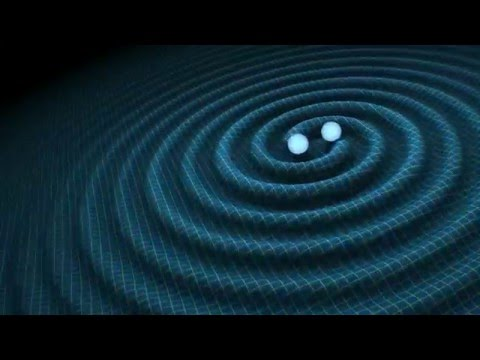

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo("Y3eR49ogsF0", width=600, height=400)

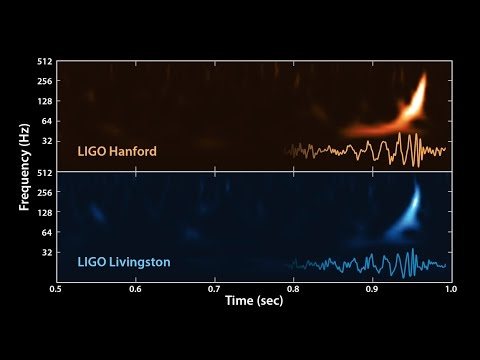

In [ ]:
YouTubeVideo("QyDcTbR-kEA", width=600, height=400)

## Generar los datos


En el artículo, los autores crean un conjunto de entrenamiento sintético de la siguiente manera:

* Generan señales de ondas gravitacionales que corresponden a fusiones de agujeros negros binarios sin rotación.
* Generan una serie temporal ruidosa e insertan una señal de onda gravitacional con una probabilidad de 0.5 en un momento aleatorio.

El resultado es un conjunto de series temporales de la forma

$$ s = g + \epsilon \frac{1}{R}\xi $$

donde $g$ es una señal de onda gravitacional del conjunto de referencia, $\xi$ es ruido gaussiano, $\epsilon=10^{-19}$ escala la amplitud del ruido respecto a la señal, y $R \in (0.075, 0.65)$ es un parámetro que controla la relación señal-ruido (SNR).


## Relación señal-ruido constante


Como calentamiento, generemos algunas señales ruidosas con una relación señal-ruido (SNR) constante de 17.98. Como se muestra en la Tabla 1 del artículo, esto corresponde a un valor de $R$ de 0.65. Al elegir el extremo superior del intervalo, nos colocamos en un escenario favorable y, por lo tanto, podemos tener una idea del mejor rendimiento posible para nuestro clasificador de series temporales.

Elegimos un número pequeño de muestras para que los cálculos se realicen rápidamente, pero en la práctica esto se escalaría entre 1 y 2 órdenes de magnitud, como se hizo en el artículo original.


In [ ]:
from pathlib import Path

R = 0.65
n_signals = 100
DATA = Path(".")

noisy_signals, gw_signals, labels = make_gravitational_waves(
    path_to_data=DATA, n_signals=n_signals, r_min=R, r_max=R, n_snr_values=1
)

print(f"Number of noisy signals: {len(noisy_signals)}")
print(f"Number of timesteps per series: {len(noisy_signals[0])}")

Number of noisy signals: 100
Number of timesteps per series: 8692


A continuación, visualicemos los dos tipos diferentes de series temporales que deseamos clasificar: una que consiste únicamente en ruido, y otra que está compuesta por ruido más una señal de onda gravitacional incrustada:


In [ ]:
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# get the index corresponding to the first pure noise time series
background_idx = np.argmin(labels)
# get the index corresponding to the first noise + gravitational wave time series
signal_idx = np.argmax(labels)

ts_noise = noisy_signals[background_idx]
ts_background = noisy_signals[signal_idx]
ts_signal = gw_signals[signal_idx]

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_noise))), y=ts_noise, mode="lines", name="noise"),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=list(range(len(ts_background))),
        y=ts_background,
        mode="lines",
        name="background",
    ),
    row=1,
    col=2,
)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_signal))), y=ts_signal, mode="lines", name="signal"),
    row=1,
    col=2,
)
fig.show()

Hacemos dos observaciones:
1. Es difícil distinguir la señal a simple vista,
2. La señal presenta cierta regularidad o periodicidad.

Ambas observaciones nos llevan a examinar la _**incrustación de Takens**_ de la señal $s(t)$, con el fin de capturar su estructura recurrente. De hecho, si $f$ se toma de un sistema dinámico con una estructura recurrente no trivial, entonces, con los parámetros adecuados, la imagen bajo la incrustación tendrá una topología no trivial.

Más formalmente, extraemos una secuencia de vectores en $\mathbb{R}^{d}$ de la forma

$$
TD_{d,\tau} s : \mathbb{R} \to \mathbb{R}^{d}\,, \qquad t \to \begin{bmatrix}
           s(t) \\
           s(t + \tau) \\
           s(t + 2\tau) \\
           \vdots \\
           s(t + (d-1)\tau)
         \end{bmatrix},
$$

donde $d$ es la dimensión de la incrustación y $\tau$ es el retardo de tiempo. La cantidad $(d-1)\tau$ se conoce como el "tamaño de ventana" y la diferencia entre $t_{i+1}$ y $t_i$ se denomina paso (*stride*).

Veamos cómo se ve la incrustación por retardo temporal de una señal pura de onda gravitacional:


In [ ]:
from gtda.time_series import SingleTakensEmbedding
embedding_dimension = 30
embedding_time_delay = 30
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_gw_embedded = embedder.fit_transform(gw_signals[0])

Podemos usar PCA para proyectar nuestro espacio de alta dimensión a 3 dimensiones para su visualización:


In [ ]:
from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud

pca = PCA(n_components=3)
y_gw_embedded_pca = pca.fit_transform(y_gw_embedded)

plot_point_cloud(y_gw_embedded_pca)

¡A partir de la gráfica podemos ver que la señal periódica decreciente generada por la fusión de agujeros negros aparece como una _espiral_ en el espacio de incrustación por retardo temporal!

Para contrastar, comparemos esto con una de las series temporales de ruido puro en nuestra muestra:


In [ ]:
embedding_dimension = 30
embedding_time_delay = 30
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_noise_embedded = embedder.fit_transform(noisy_signals[background_idx])

pca = PCA(n_components=3)
y_noise_embedded_pca = pca.fit_transform(y_noise_embedded)

plot_point_cloud(y_noise_embedded_pca)

Evidentemente, el ruido puro se asemeja a una esfera de alta dimensión en el espacio de incrustación por retardo temporal. Veamos si podemos utilizar homología persistente para distinguir qué series temporales contienen una señal de onda gravitacional y cuáles no. Para ello, adaptaremos la estrategia del artículo original:

1. Generar incrustaciones por retardo temporal de 200 dimensiones para cada serie temporal  
2. Utilizar PCA para reducir las incrustaciones a 3 dimensiones  
3. Usar la construcción de Vietoris-Rips para calcular los diagramas de persistencia de los generadores de $H_0$ y $H_1$  
4. Extraer vectores de características utilizando la entropía de persistencia  
5. Entrenar un clasificador binario usando las características topológicas


### Definir el pipeline de generación de características topológicas


Podemos realizar los pasos 1 y 2 utilizando las siguientes herramientas de ``giotto-tda``:

- El transformador ``TakensEmbedding`` – en lugar de ``SingleTakensEmbedding`` – que transformará cada serie temporal en ``noisy_signals`` por separado y devolverá una colección de nubes de puntos;
- ``CollectionTransformer``, que es un "meta-estimador" conveniente para aplicar el mismo PCA a cada nube de puntos resultante del paso 1.

Usando la clase ``Pipeline`` de ``giotto-tda``, podemos encadenar todas las operaciones hasta e incluyendo el paso 4 de la siguiente manera:


In [ ]:
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.homology import VietorisRipsPersistence
from gtda.metaestimators import CollectionTransformer
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding

embedding_dimension = 200
embedding_time_delay = 10
stride = 10

embedder = TakensEmbedding(time_delay=embedding_time_delay,
                           dimension=embedding_dimension,
                           stride=stride)

batch_pca = CollectionTransformer(PCA(n_components=3), n_jobs=-1)

persistence = VietorisRipsPersistence(homology_dimensions=[0, 1, 2], n_jobs=-1)

scaling = Scaler()

entropy = PersistenceEntropy(normalize=True, nan_fill_value=-10)


steps = [("embedder", embedder),
         ("pca", batch_pca),
         ("persistence", persistence),
         ("scaling", scaling),
         ("entropy", entropy)]
topological_transfomer = Pipeline(steps)

In [ ]:
features = topological_transfomer.fit_transform(noisy_signals)

In [ ]:
import pandas as pd

In [ ]:
noisy_df = pd.DataFrame(noisy_signals)
features_df = pd.DataFrame(features)
features_df.columns = ['features 0', 'features 1', 'features 2']

noisy_df_normalized = noisy_df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

features_df_normalized = features_df.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

df = pd.concat([noisy_df_normalized,
                features_df_normalized], axis=1)

# Convert all column names to strings
df.columns = df.columns.astype(str)
df

,0,1,2,3,4,5,6,7,8,9,...,8685,8686,8687,8688,8689,8690,8691,features 0,features 1,features 2
0,0.439379,-0.550101,-0.601454,-2.327461,-0.886620,0.651729,0.254520,-0.062280,0.315684,-1.538088,...,-0.212267,-0.111260,1.627265,0.377904,-0.036021,1.691893,0.532136,-3.199270,-2.491408,-0.412060
1,1.285897,0.938308,1.316324,1.092648,1.450250,1.836944,-0.079849,-0.810554,0.249686,-1.089007,...,0.653003,1.878415,1.452489,-0.247595,-1.196266,-3.032876,1.138360,-0.044206,0.192589,1.403515
2,0.949964,0.119985,1.775309,0.386317,0.046082,-0.444611,-1.136574,-0.767234,0.382925,0.784362,...,0.134914,-0.249126,-0.341806,-1.057494,0.261855,-0.665772,0.642779,-0.829868,0.014218,0.037437
3,0.109613,-1.239194,-1.506908,-0.433261,1.159715,-2.583871,-0.387199,-0.120521,0.399283,0.853104,...,-2.345534,-1.640656,0.766435,1.506482,0.411660,0.438149,0.664703,0.246323,0.523161,0.038820
4,-0.431273,0.586751,-0.371363,-0.715582,-0.770196,-0.952453,0.584955,-0.060326,0.214618,0.006838,...,-0.111128,0.039377,0.687021,-0.167476,-0.561893,-0.111702,-0.820001,0.998248,1.327110,0.813274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.466051,-1.849650,-0.243439,-0.453472,-1.267910,-0.588915,0.520788,1.598330,2.336660,0.358904,...,0.513954,0.870995,-1.387810,1.106107,-1.005257,1.636090,0.794707,-0.318122,0.621474,-0.024460
96,0.807791,0.647402,-0.640020,1.093561,-2.019973,-0.434030,1.304987,0.681430,-0.816417,-0.028483,...,0.121824,-1.677954,-0.626781,0.081998,1.433246,-1.264585,-0.158930,0.553258,0.398041,0.197591
97,0.815112,0.796762,-0.147043,2.062557,0.851283,0.010512,-0.376365,0.958896,-0.038863,-0.338808,...,-0.112701,0.191405,-1.573934,-0.781747,-0.719712,1.731010,-0.556083,-1.083559,-0.956956,-0.141745
98,-0.146827,0.781517,-0.620361,0.033183,-0.030049,0.954179,0.761438,-0.058974,0.134137,-0.962395,...,1.167398,1.311257,1.287347,-0.517786,-1.879396,0.892981,-0.874286,-0.100241,-0.533478,0.013100


### Entrenar y evaluar un modelo


Para el paso final, entrenemos un clasificador sencillo usando nuestras características topológicas. Como es habitual, creamos conjuntos de entrenamiento y validación.


# **Clasificadores**

**Pre-procesamiento y métricas de evaluación**

Se dividió el conjunto de datos en conjuntos de entrenamiento y validación usando `train_test_split`, reservando el 30 % de los datos para validación. Luego, se definió una función llamada `print_scores` que evalúa un modelo entrenado calculando su precisión (Accuracy) y el área bajo la curva ROC (ROC AUC), tanto en el conjunto de entrenamiento como en el de validación. Estos indicadores permiten medir qué tan bien se desempeña el modelo al clasificar correctamente las series temporales con o sin señales de ondas gravitacionales.


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    df, labels, test_size=0.3, random_state=42
)

In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,8685,8686,8687,8688,8689,8690,8691,features 0,features 1,features 2
11,-0.269367,-0.307003,0.136808,1.465521,0.846678,-0.066415,0.824139,1.287717,0.564142,0.126765,...,-0.775940,-0.611196,-0.950477,0.341892,0.394572,1.177278,-0.437059,0.715102,0.915264,0.132261
47,0.991796,0.461772,0.522149,-2.220561,1.906548,1.150669,-2.812599,-0.986348,0.277377,1.092283,...,0.129919,-1.324502,-0.426165,-1.218401,-0.980155,0.029090,1.193464,-0.885856,0.598957,0.359341
85,-0.058520,-1.155756,-0.322579,0.284512,0.743853,-0.120786,0.009245,0.815697,0.006832,-1.407592,...,-0.211015,0.097357,0.601111,-0.444492,-1.339422,1.271687,1.042878,0.445561,0.629287,0.183901
28,0.948001,0.546728,-0.408963,2.134069,1.056962,-1.805101,-0.110902,0.795207,-1.262831,-1.303402,...,-1.270376,-0.356703,1.528051,-1.496718,-0.294836,0.041865,1.110842,0.488452,0.010025,0.128386
93,0.095922,0.968030,0.286627,0.335794,-0.865765,-2.053395,0.800170,0.672418,0.581640,0.064667,...,1.474738,-0.048831,0.008327,-1.037242,-0.284934,-0.145442,-0.897492,0.466080,1.104484,0.146486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,-0.002504,-2.141937,-2.739869,1.429907,-0.129540,0.095023,-1.233790,-1.240972,-0.457630,-0.435048,...,-0.827975,1.259835,0.160212,-0.039889,-0.285040,0.561085,0.133471,1.256811,0.720222,0.236592
71,-0.057046,0.141525,0.358939,0.823076,1.782734,-1.275474,0.352816,-0.090048,-0.312532,-1.095212,...,0.060027,-1.217035,-0.473067,-1.423360,-0.270956,0.670027,-0.197025,-0.025412,0.242829,-0.044492
14,0.233526,0.291908,-1.582156,-1.989323,-2.032415,0.886281,0.830245,0.657599,0.049830,-0.478756,...,0.011482,0.147057,-0.229314,0.599743,0.207507,-1.208783,-0.922173,0.293879,0.304437,0.123367
92,0.976452,0.951412,-0.793333,-1.395310,0.540841,0.793033,-0.171877,-0.315558,-0.813806,-0.299657,...,-3.441089,0.340725,0.145999,1.691092,0.650074,0.145921,2.042785,0.612315,0.866140,0.257950


In [ ]:
y_train

array([0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
       1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 1.])

In [ ]:
X_valid

,0,1,2,3,4,5,6,7,8,9,...,8685,8686,8687,8688,8689,8690,8691,features 0,features 1,features 2
83,-1.150637,1.231953,-1.188591,0.080480,0.934985,1.011489,-0.410903,-0.324711,0.117131,-1.567371,...,-2.185396,0.036423,-0.758433,0.647462,1.900713,-0.942071,-1.172075,0.331469,0.029572,-0.005899
53,-0.955406,0.251846,0.289932,-0.971450,0.429607,-0.776358,-0.353747,1.553804,0.088176,0.605726,...,0.780481,0.486224,-0.869366,-0.354125,-1.443934,1.649263,1.085355,-1.107709,-0.243511,-0.065963
70,-1.642483,0.081004,-0.090155,-1.538885,1.614076,0.664938,0.529295,0.402428,-0.663380,0.461451,...,0.696673,1.638498,-1.025671,0.542120,0.370744,-0.962136,-0.006859,0.224415,-0.057952,0.016812
45,-1.411886,-0.248105,2.120184,1.271430,1.259799,-0.949312,0.491188,1.847924,-0.303498,0.407564,...,-0.919244,-1.042961,-1.379767,0.394365,1.458947,-0.170720,0.852816,-0.343409,0.053951,-0.056942
44,-1.243803,1.204777,0.675799,1.486447,-1.724840,-1.279333,-0.871904,-3.256184,0.011504,0.045764,...,1.274473,0.597073,-1.499105,-0.841658,1.173264,1.807740,-0.051434,0.617900,0.563218,0.129721
39,-1.099282,-0.160071,-1.142254,-1.922877,0.622587,-1.979700,0.022905,-1.581366,0.025774,-0.996081,...,-0.856778,-0.779571,-0.842005,1.798590,-0.366635,-1.207678,-1.089591,0.638606,0.637394,0.374414
22,-0.599791,-1.025327,-2.407143,-1.031857,-0.403136,-0.926555,-0.849537,0.354575,-1.617782,1.241784,...,0.431574,0.929171,-1.395160,2.315194,-0.371763,0.564527,1.658330,0.582235,-0.175314,-0.163762
80,-0.527992,2.011018,0.298000,-1.483983,0.628084,0.894844,0.676244,-0.705571,0.667929,1.914312,...,-2.454818,0.395884,2.117153,1.335179,0.118400,0.882968,1.135963,0.693912,0.690027,0.143318
10,-1.530095,0.145930,0.110304,-0.926205,-0.542661,-0.197152,-0.318057,-2.031087,-0.003616,1.063203,...,-0.187848,0.227843,0.129887,0.504714,-0.711902,0.425486,0.077987,0.791506,0.648310,0.159701
0,0.439379,-0.550101,-0.601454,-2.327461,-0.886620,0.651729,0.254520,-0.062280,0.315684,-1.538088,...,-0.212267,-0.111260,1.627265,0.377904,-0.036021,1.691893,0.532136,-3.199270,-2.491408,-0.412060


In [ ]:
y_valid

array([0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0.])


y luego ajustamos y evaluamos nuestro modelo:


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import precision_score

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

def print_scores(fitted_model):
    res = {
        "Accuracy on train:": accuracy_score(fitted_model.predict(X_train), y_train),
        "ROC AUC on train:": roc_auc_score(
            y_train, fitted_model.predict_proba(X_train)[:, 1]
        ),
        "Accuracy on valid:": accuracy_score(fitted_model.predict(X_valid), y_valid),
        "ROC AUC on valid:": roc_auc_score(
            y_valid, fitted_model.predict_proba(X_valid)[:, 1]
        ),
    }

    for k, v in res.items():
        print(k, round(v, 3))

# **Regresión Logística**

Se entrenó un modelo de regresión logística (`LogisticRegression`) utilizando las características topológicas extraídas previamente. Luego, se evaluó el modelo tanto en el conjunto de entrenamiento como en el de validación usando métricas como `accuracy` (precisión global) y `ROC AUC` (área bajo la curva ROC), además de generar reportes de clasificación y matrices de confusión visualizadas con `seaborn`.



In [ ]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(X_train, y_train)
print_scores(LR)

Accuracy on train: 1.0
ROC AUC on train: 1.0
Accuracy on valid: 0.667
ROC AUC on valid: 0.57


In [ ]:
print(classification_report(y_train, (LR.predict(X_train)).astype(int)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        37
         1.0       1.00      1.00      1.00        33

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70



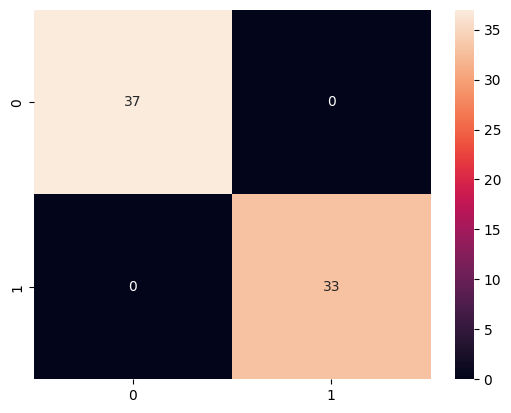

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_train, (LR.predict(X_train)).astype(int))
sns.heatmap(cm, annot = True)
plt.show()

In [ ]:
print(classification_report(y_valid, (LR.predict(X_valid)).astype(int)))

              precision    recall  f1-score   support

         0.0       0.67      0.82      0.74        17
         1.0       0.67      0.46      0.55        13

    accuracy                           0.67        30
   macro avg       0.67      0.64      0.64        30
weighted avg       0.67      0.67      0.65        30



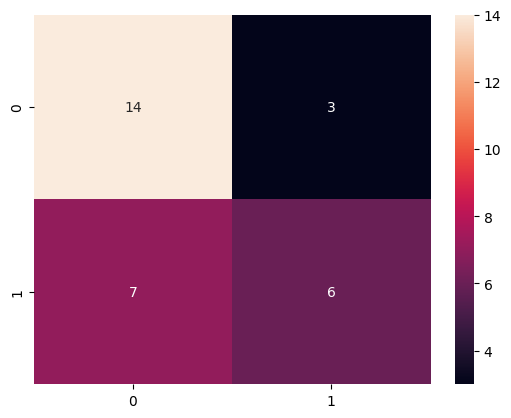

In [ ]:
cm = confusion_matrix(y_valid, (LR.predict(X_valid)).astype(int))
sns.heatmap(cm, annot = True)
plt.show()

En los resultados, el modelo alcanzó una precisión perfecta en el conjunto de entrenamiento (100 %), lo que sugiere sobreajuste. Esto se refleja también en la matriz de confusión, donde todos los ejemplos se clasificaron correctamente. Sin embargo, en el conjunto de validación, la precisión cayó a 66.7 % y el ROC AUC fue de 0.57, lo cual indica que el modelo no generaliza bien y tiene dificultades para distinguir entre ruido y señales reales en datos nuevos. La matriz de confusión de validación muestra varios falsos negativos (ondas mal clasificadas como ruido), lo que evidencia una limitación importante que podría mejorarse con regularización, más datos o un modelo más complejo.

# ***Random Forest Classifier***

Se entrenó un modelo `RandomForestClassifier` usando el conjunto de entrenamiento `X_train` y `y_train`, y se evaluó su rendimiento con la función `print_scores`, que muestra métricas como precisión (`accuracy`) y área bajo la curva ROC (`ROC AUC`) para entrenamiento y validación. Posteriormente, se imprimió el reporte de clasificación (`classification_report`) para visualizar precisión, recall y F1-score por clase, seguido por las matrices de confusión de entrenamiento y validación utilizando `seaborn.heatmap` para facilitar la interpretación visual de los aciertos y errores del modelo.


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print_scores(rf)

Accuracy on train: 1.0
ROC AUC on train: 1.0
Accuracy on valid: 0.433
ROC AUC on valid: 0.394


In [ ]:
print(classification_report(y_train, (rf.predict(X_train)).astype(int)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        37
         1.0       1.00      1.00      1.00        33

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70



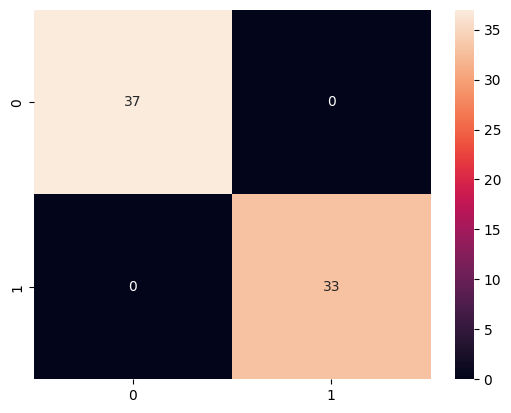

In [ ]:
cm = confusion_matrix(y_train, (rf.predict(X_train)).astype(int))
sns.heatmap(cm, annot = True)
plt.show()

In [ ]:
print(classification_report(y_valid, (rf.predict(X_valid)).astype(int)))

              precision    recall  f1-score   support

         0.0       0.50      0.65      0.56        17
         1.0       0.25      0.15      0.19        13

    accuracy                           0.43        30
   macro avg       0.38      0.40      0.38        30
weighted avg       0.39      0.43      0.40        30



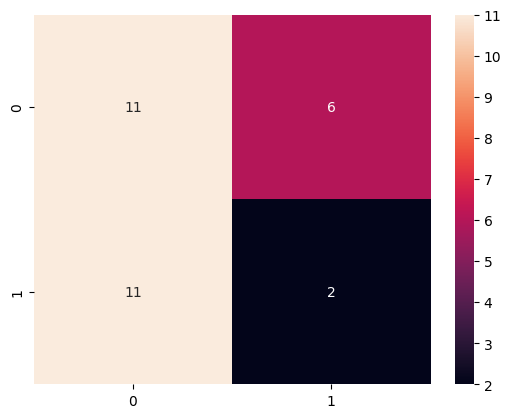

In [ ]:
cm = confusion_matrix(y_valid, (rf.predict(X_valid)).astype(int))
sns.heatmap(cm, annot = True)
plt.show()

El modelo de Random Forest mostró un rendimiento perfecto en el conjunto de entrenamiento, con un 100 % de precisión y métricas perfectas en el reporte de clasificación, lo que indica un fuerte sobreajuste. En cambio, su rendimiento en el conjunto de validación fue bajo: una precisión de solo 43.3 % y un ROC AUC de 0.394. La matriz de confusión de validación revela una dificultad considerable para identificar correctamente las señales de onda gravitacional (clase 1), con solo 2 aciertos y 11 falsos negativos. Estos resultados reflejan que, aunque el modelo puede memorizar bien los datos de entrenamiento, falla al generalizar a nuevos datos, sugiriendo que necesita ajustes como reducción de complejidad, más datos o técnicas de regularización.



# ***Convolutional Neural Networks***

# **Red del *Paper*: *MaxPooling***

Se construyó una red neuronal convolucional secuencial en Keras para clasificar señales de ondas gravitacionales. El modelo está compuesto por cuatro bloques de capas `Conv1D` seguidos de capas `MaxPooling1D`, que extraen y reducen las características relevantes de las series temporales. Luego, se aplanan las salidas con `Flatten()` y se pasan por varias capas densas (`Dense`) para realizar la clasificación binaria final mediante una activación `sigmoid`. El modelo fue compilado con el optimizador `Adam` y función de pérdida `binary_crossentropy`, y se entrenó durante 10 épocas con un `validation_split` de 0.2. Finalmente, se graficó la curva de pérdida y se evaluó el modelo sobre el conjunto de validación.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input, Reshape, ReLU
from tensorflow.keras.optimizers import Adam

In [ ]:
cnn1 = Sequential()

cnn1.add(Input(shape=(X_train.shape[1], 1)))

# Bloque 1
cnn1.add(Conv1D(32, kernel_size=16, strides=1, activation='relu'))
cnn1.add(MaxPooling1D(pool_size=4, strides=4))

# Bloque 2
cnn1.add(Conv1D(64, kernel_size=16, strides=1, activation='relu'))
cnn1.add(MaxPooling1D(pool_size=4, strides=4))

# Bloque 3
cnn1.add(Conv1D(128, kernel_size=16, strides=1, activation='relu'))
cnn1.add(MaxPooling1D(pool_size=4, strides=4))

# Bloque 4
cnn1.add(Conv1D(256, kernel_size=32, strides=1, activation='relu'))
cnn1.add(MaxPooling1D(pool_size=4, strides=4))

# Salida
cnn1.add(Flatten())
cnn1.add(Dense(128, activation='linear'))
cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(64, activation='linear'))
cnn1.add(Dense(64, activation='relu'))
cnn1.add(Dense(1, activation='sigmoid'))

cnn1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8680, 32)       │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2170, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2155, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 538, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 523, 128)       │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 130, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 99, 256)        │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 24, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       786,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,028,961 (7.74 MB)

 Trainable params: 2,028,961 (7.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7759 - loss: 0.5099 - val_accuracy: 0.7857 - val_loss: 0.3775
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8696 - loss: 0.4071 - val_accuracy: 0.9286 - val_loss: 0.2443
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9327 - loss: 0.2220 - val_accuracy: 0.9286 - val_loss: 0.0818
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0483 - val_accuracy: 1.0000 - val_loss: 0.0128
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.0239 - val_accuracy: 1.0000 - val_loss: 0.0251
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9711 - loss: 0.0530 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9699 - loss: 0.0581 - val_accuracy: 0.9286 - val_loss: 0.2449
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9699 - loss: 0.0351 - val_accuracy: 1.0000 - val_loss: 1.1469e-0

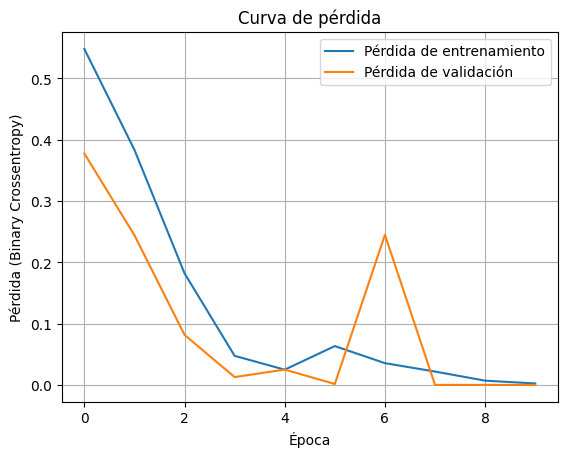

In [ ]:
# Compilar
optimizer = Adam(learning_rate=0.001)
cnn1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar
history = cnn1.fit(X_train, y_train, validation_split=0.2,
                  epochs=10,  # como en el paper
                  batch_size=16)

# Visualizar curva de pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida (Binary Crossentropy)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
loss, accuracy = cnn1.evaluate(X_valid, y_valid)
print('Exactitud del modelo:', accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step - accuracy: 1.0000 - loss: 0.0282
Exactitud del modelo: 1.0


In [ ]:
# Usamos el modelo para predecir
y_pred = (cnn1.predict(X_valid)).astype(int)

# Resumen de los primeros 25 casos
for i in range(25): print('%d (Esperado: %d)' % (y_pred[i], y_valid[i]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
0 (Esperado: 0)
0 (Esperado: 1)
0 (Esperado: 0)
1 (Esperado: 1)
0 (Esperado: 0)
1 (Esperado: 1)
0 (Esperado: 0)
0 (Esperado: 0)
1 (Esperado: 1)
1 (Esperado: 1)
0 (Esperado: 0)
0 (Esperado: 1)
0 (Esperado: 0)
0 (Esperado: 0)
0 (Esperado: 0)
0 (Esperado: 1)
0 (Esperado: 0)
1 (Esperado: 1)
0 (Esperado: 0)
0 (Esperado: 1)
1 (Esperado: 1)
0 (Esperado: 0)
0 (Esperado: 1)
0 (Esperado: 0)
0 (Esperado: 0)


<ipython-input-39-3351637488>:5: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



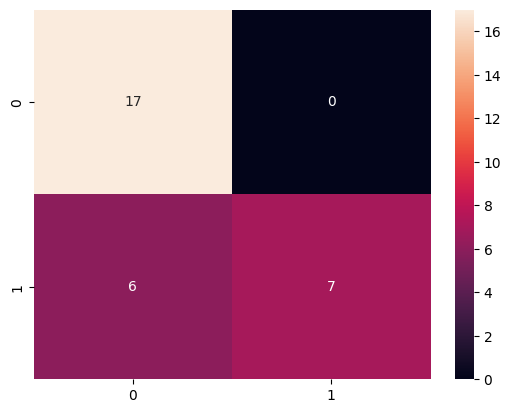

In [ ]:
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot = True)
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 347ms/step


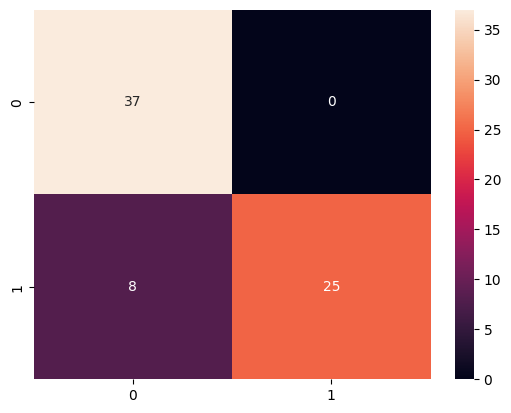

In [ ]:
cm = confusion_matrix(y_train, (cnn1.predict(X_train)).astype(int))
sns.heatmap(cm, annot = True)
plt.show()

In [ ]:
print(classification_report(y_train, (cnn1.predict(X_train)).astype(int)))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90        37
         1.0       1.00      0.76      0.86        33

    accuracy                           0.89        70
   macro avg       0.91      0.88      0.88        70
weighted avg       0.91      0.89      0.88        70



In [ ]:
print(classification_report(y_valid, (cnn1.predict(X_valid)).astype(int)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
              precision    recall  f1-score   support

         0.0       0.74      1.00      0.85        17
         1.0       1.00      0.54      0.70        13

    accuracy                           0.80        30
   macro avg       0.87      0.77      0.78        30
weighted avg       0.85      0.80      0.79        30



Durante el entrenamiento, la red mostró una mejora rápida en precisión y reducción de pérdida en las primeras épocas, alcanzando una exactitud perfecta tanto en el entrenamiento como en la validación en algunas iteraciones. Sin embargo, la matriz de confusión y los reportes de clasificación revelan que, aunque el modelo predijo correctamente muchos casos, también incurrió en falsos negativos al identificar ondas gravitacionales (clase 1). La precisión general en validación fue del 80 %, con una F1-score de 0.70 para la clase 1, lo que indica un buen desempeño general con espacio para mejorar en la sensibilidad hacia señales más sutiles. La gráfica de pérdida sugiere cierto sobreajuste en épocas tardías, aunque no de forma severa.


# **Red 2: *AvgPooling***

Se construyó una red neuronal convolucional de tipo `Sequential` usando `Conv1D` y `AveragePooling1D` para el procesamiento de señales unidimensionales. La arquitectura incluye cuatro bloques convolucionales con capas `Conv1D` activadas por `ReLU`, seguidas de `AveragePooling1D` para reducir la dimensionalidad. Luego, la salida se aplana y pasa por una serie de capas densas (`Dense`), culminando en una capa con activación `sigmoid` para realizar la clasificación binaria. El modelo se entrenó durante 10 épocas con `binary_crossentropy` como función de pérdida y se evaluó tanto en entrenamiento como en validación. También se generaron gráficas de pérdida y matrices de confusión.


In [ ]:
from tensorflow.keras.layers import AveragePooling1D

In [ ]:
model2 = Sequential()

model2.add(Input(shape=(X_train.shape[1], 1)))  # Ajusta la dimensión según tu entrada

# Bloque 1
model2.add(Conv1D(32, kernel_size=16, strides=1, activation='relu'))
model2.add(AveragePooling1D(pool_size=4, strides=4))

# Bloque 2
model2.add(Conv1D(64, kernel_size=16, strides=1, activation='relu'))
model2.add(AveragePooling1D(pool_size=4, strides=4))

# Bloque 3
model2.add(Conv1D(128, kernel_size=16, strides=1, activation='relu'))
model2.add(AveragePooling1D(pool_size=4, strides=4))

# Bloque 4
model2.add(Conv1D(256, kernel_size=32, strides=1, activation='relu'))
model2.add(AveragePooling1D(pool_size=4, strides=4))

# Salida
model2.add(Flatten())
model2.add(Dense(128, activation='linear'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='linear'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 8680, 32)       │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 2170, 32)       │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 2155, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 538, 64)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 523, 128)       │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_2             │ (None, 130, 128)       │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 99, 256)        │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_3             │ (None, 24, 256)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       786,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,028,961 (7.74 MB)

 Trainable params: 2,028,961 (7.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4929 - loss: 0.7076 - val_accuracy: 0.5714 - val_loss: 0.6859
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5690 - loss: 0.6872 - val_accuracy: 0.4286 - val_loss: 0.6549
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6077 - loss: 0.5690 - val_accuracy: 0.6429 - val_loss: 0.4046
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7735 - loss: 0.4170 - val_accuracy: 0.7143 - val_loss: 0.4906
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9399 - loss: 0.2974 - val_accuracy: 1.0000 - val_loss: 0.0418
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9887 - loss: 0.0861 - val_accuracy: 1.0000 - val_loss: 0.0466
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9699 - loss: 0.2337 - val_accuracy: 1.0000 - val_loss: 3.0933e-04
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9824 - loss: 0.0430 - val_accuracy: 1.0000 - val_loss: 0.002

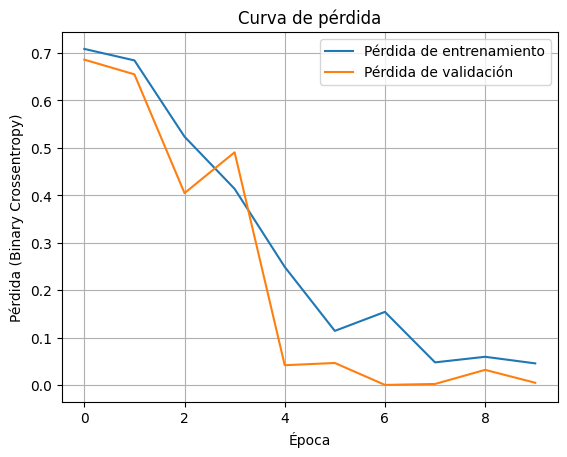

In [ ]:
# Compilar
optimizer = Adam(learning_rate=0.001)
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar
history = model2.fit(X_train, y_train, validation_split=0.2,
                    epochs=10,  # como en el paper
                    batch_size=16)

# Visualizar curva de pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curva de pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida (Binary Crossentropy)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
loss, accuracy = model2.evaluate(X_valid, y_valid)
print('Exactitud del modelo:', accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9333 - loss: 0.1436
Exactitud del modelo: 0.9333333373069763


In [ ]:
# Usamos el modelo para predecir
y_pred = (model2.predict(X_valid)).astype(int)

# Resumen de los primeros 25 casos
for i in range(25): print('%d (Esperado: %d)' % (y_pred[i], y_valid[i]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
0 (Esperado: 0)
1 (Esperado: 1)
0 (Esperado: 0)
1 (Esperado: 1)
0 (Esperado: 0)
1 (Esperado: 1)
0 (Esperado: 0)
0 (Esperado: 0)
1 (Esperado: 1)
1 (Esperado: 1)
0 (Esperado: 0)
0 (Esperado: 1)
0 (Esperado: 0)
0 (Esperado: 0)
0 (Esperado: 0)
0 (Esperado: 1)
0 (Esperado: 0)
1 (Esperado: 1)
0 (Esperado: 0)
1 (Esperado: 1)
1 (Esperado: 1)
0 (Esperado: 0)
0 (Esperado: 1)
0 (Esperado: 0)
0 (Esperado: 0)


<ipython-input-49-3859368574>:5: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



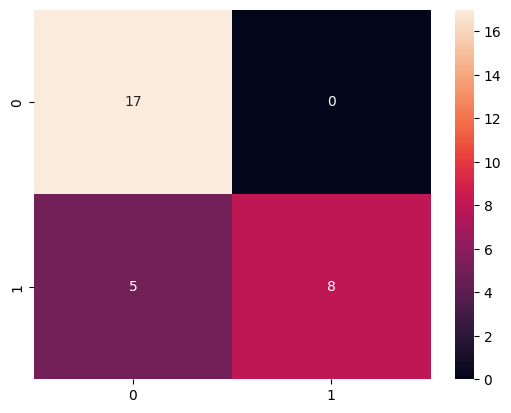

In [ ]:
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot = True)
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


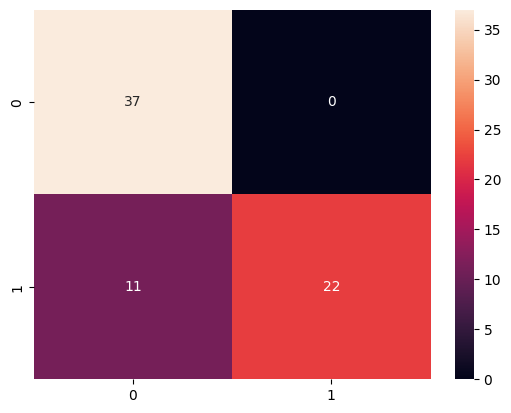

In [ ]:
cm = confusion_matrix(y_train, (model2.predict(X_train)).astype(int))
sns.heatmap(cm, annot = True)
plt.show()

In [ ]:
print(classification_report(y_train, (model2.predict(X_train)).astype(int)))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87        37
         1.0       1.00      0.67      0.80        33

    accuracy                           0.84        70
   macro avg       0.89      0.83      0.84        70
weighted avg       0.88      0.84      0.84        70



In [ ]:
print(classification_report(y_valid, (model2.predict(X_valid)).astype(int)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87        17
         1.0       1.00      0.62      0.76        13

    accuracy                           0.83        30
   macro avg       0.89      0.81      0.82        30
weighted avg       0.87      0.83      0.82        30



El modelo con `AveragePooling` mostró un desempeño sólido, alcanzando una precisión del 93.3 % en el conjunto de validación con una pérdida de 0.14. Durante el entrenamiento, tanto la pérdida como la precisión mejoraron progresivamente, y la curva de pérdida indica una buena convergencia sin señales evidentes de sobreajuste. Sin embargo, el modelo mostró cierta dificultad al clasificar correctamente todas las instancias de la clase 1 (ondas gravitacionales), cometiendo 5 falsos negativos. A pesar de ello, el modelo logró una F1-score de 0.76 para esa clase y un desempeño general equilibrado, ligeramente inferior al modelo con `MaxPooling`, pero con un buen nivel de generalización.


# **Conclusión General**

Este proyecto implementa un enfoque para la detección de ondas gravitacionales inspirándose en el trabajo de Bresten y Jung, combinando técnicas de análisis topológico con aprendizaje automático y redes neuronales profundas. Se parte de un conjunto de señales sintéticas que emulan colisiones de agujeros negros inmersas en ruido gaussiano, con diferentes relaciones señal-ruido (SNR).

Primero, se aplicó la incrustación de Takens para representar las señales en un espacio de mayor dimensión donde emergen patrones topológicos. Estas representaciones fueron reducidas a tres dimensiones mediante PCA y convertidas en características numéricas usando diagramas de persistencia (`VietorisRipsPersistence`) y entropía de persistencia.

Con estas características, se entrenaron múltiples clasificadores:

- **Modelos clásicos** como Regresión Logística y Random Forest demostraron sobreajuste severo o bajo rendimiento en validación.
- **Redes neuronales convolucionales (CNN)** superaron ampliamente a los modelos clásicos. La arquitectura basada en **MaxPooling** alcanzó una precisión del 80 %, mientras que la versión con **AveragePooling** llegó al 83 %, ambas con buen balance entre precisión y sensibilidad para detectar señales reales.
- La combinación de CNN + reducción de dimensionalidad + extracción topológica probó ser efectiva, como se mostró tanto en las curvas de pérdida como en las matrices de confusión.

En resumen, el uso de topología algebraica para enriquecer los datos de entrada, seguido de una CNN especializada, constituye una estrategia poderosa para detectar patrones sutiles en series temporales ruidosas, validando las hipótesis planteadas en el artículo original.
